Isolation Forest for Anomaly Detection

In [34]:
import zipfile
import os

zip_path = "C:/Users/ey896/Downloads/archive.zip"        # 데이터 가져오기
extract_dir = "/Users/ey896/Downloads/Dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

os.listdir(extract_dir)

['access.log', 'client_hostname.csv', 'labeled.csv']

In [35]:
import pandas as pd

csv_path = "/Users/ey896/Downloads/Dataset/labeled.csv"

df = pd.read_csv(csv_path)

df      #데이터셋 확인


,ip,time,method,url,protocol,status,size,referrer,user_agent,extra,no,label,type
0,31.56.96.51,2019-01-22 00:26:16+00:00,GET,/image/60844/productModel/200x200,HTTP/1.1,200,5667,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,-,2,0,benign
1,31.56.96.51,2019-01-22 00:26:16+00:00,GET,/image/61474/productModel/200x200,HTTP/1.1,200,5379,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,-,3,0,benign
2,91.99.72.15,2019-01-22 00:26:17+00:00,GET,/product/31893/62100/سشوار-خانگی-پرنسلی-مدل-PR...,HTTP/1.1,200,41483,-,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...,-,5,0,benign
3,178.253.33.51,2019-01-22 00:26:19+00:00,GET,/m/product/32574/62991/ماشین-اصلاح-صورت-پرنسلی...,HTTP/1.1,200,20406,"https://www.zanbil.ir/m/filter/p5767,t156?name...",Mozilla/5.0 (Linux; Android 5.1; HTC Desire 72...,-,13,0,benign
4,91.99.72.15,2019-01-22 00:26:19+00:00,GET,/product/10075/13903/مایکروفر-رومیزی-سامسونگ-م...,HTTP/1.1,200,41725,-,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,-,15,0,benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9282179,188.229.21.56,2019-01-26 16:59:13+00:00,GET,/content/view/shoppingRules,HTTP/1.1,302,0,https://www.zanbil.ir/m/product/32106/62372/ما...,Mozilla/5.0 (Linux; Android 7.0; SM-N920C Buil...,-,10365148,0,benign
9282180,5.127.220.71,2019-01-26 16:59:13+00:00,GET,/apple-touch-icon-120x120.png,HTTP/1.1,404,32420,-,MobileSafari/604.1 CFNetwork/976 Darwin/18.2.0,-,10365149,0,benign
9282181,5.213.7.50,2019-01-26 16:59:13+00:00,GET,/m/product/18962/غذا-ساز-مولینکس-مدل-FP7367RT,HTTP/1.1,200,20959,https://www.google.com/,Mozilla/5.0 (iPhone; CPU iPhone OS 10_2_1 like...,-,10365150,0,benign
9282182,109.125.169.52,2019-01-26 16:59:13+00:00,GET,/image/{{basketItem.id}}?type=productModel&wh=...,HTTP/1.1,200,5,https://www.zanbil.ir/,Mozilla/5.0 (Windows NT 6.1; rv:64.0) Gecko/20...,-,10365151,0,benign


EDA

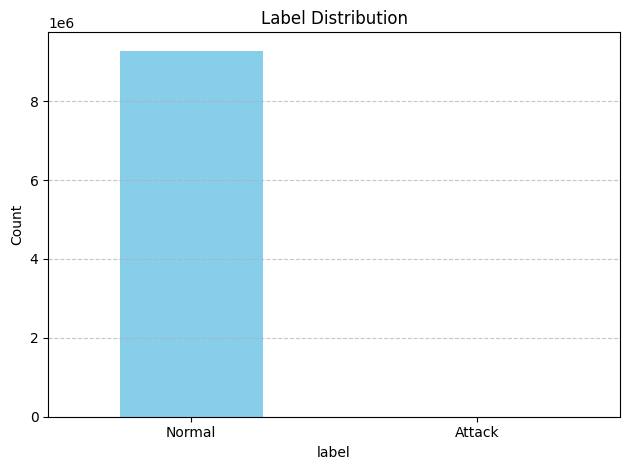

In [36]:
import matplotlib.pyplot as plt

df['label'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])        # 로그 라벨 확인 및 시각화(모두 정상)
plt.title('Label Distribution')
plt.xticks(ticks=[0, 1], labels=['Normal', 'Attack'], rotation=0)
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


위에서 사용한 데이터셋은 whttps://www.kaggle.com/datasets/mahendradata/web-server-access-logs-labeled 입니다.

 다만 원본 데이터( https://www.kaggle.com/datasets/eliasdabbas/web-server-access-logs)는 csv형태로 정렬되어있지 않아 2GB 용량의 로그를 전부 csv 하는건 시간이 너무 오래걸려서 csv로 나눠진 데이터셋 활용하였습니다.

 또한 사용한 데이터셋에서 라벨링 칼럼이 있는데 이건 공식적인게 아니라서 제거하였습니다.

 결론 : 어처피 같은 데이터셋를 기반으로 활용한거라서 발표떄는 https://www.kaggle.com/datasets/eliasdabbas/web-server-access-logs 이 주소에 있는거 썻다고 하면 됩니다.(완전 raw한 로그 데이터)

In [37]:
df = df.drop(columns=['type', 'no', 'extra', 'label'], errors='ignore')
df.head()


,ip,time,method,url,protocol,status,size,referrer,user_agent
0,31.56.96.51,2019-01-22 00:26:16+00:00,GET,/image/60844/productModel/200x200,HTTP/1.1,200,5667,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...
1,31.56.96.51,2019-01-22 00:26:16+00:00,GET,/image/61474/productModel/200x200,HTTP/1.1,200,5379,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...
2,91.99.72.15,2019-01-22 00:26:17+00:00,GET,/product/31893/62100/سشوار-خانگی-پرنسلی-مدل-PR...,HTTP/1.1,200,41483,-,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...
3,178.253.33.51,2019-01-22 00:26:19+00:00,GET,/m/product/32574/62991/ماشین-اصلاح-صورت-پرنسلی...,HTTP/1.1,200,20406,"https://www.zanbil.ir/m/filter/p5767,t156?name...",Mozilla/5.0 (Linux; Android 5.1; HTC Desire 72...
4,91.99.72.15,2019-01-22 00:26:19+00:00,GET,/product/10075/13903/مایکروفر-رومیزی-سامسونگ-م...,HTTP/1.1,200,41725,-,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...


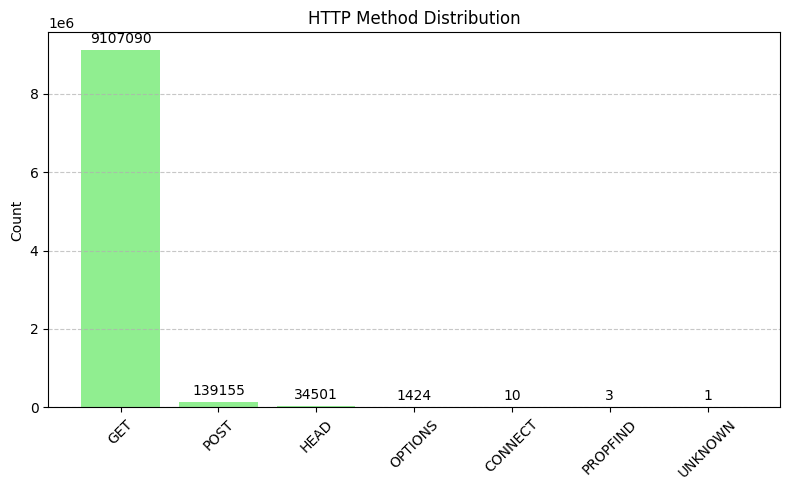

In [38]:
import matplotlib.pyplot as plt

valid_methods = {'GET', 'POST', 'PUT', 'DELETE', 'OPTIONS', 'HEAD', 'CONNECT', 'TRACE', 'PATCH', 'PROPFIND'}

# 잘못된 method는 UNKNOWN으로 대체
df['method'] = df['method'].apply(lambda x: x if x in valid_methods else 'UNKNOWN')

# 시각화
method_counts = df['method'].value_counts()

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(method_counts.index, method_counts.values, color='lightgreen')

# 막대 위에 수치 표시
ax.bar_label(ax.containers[0], fmt='%d', padding=3)

# 그래프 꾸미기
ax.set_title('HTTP Method Distribution')
ax.set_ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


이 그래프는 HTTP 요청 메소드 분포를 보여줍니다.
전체 로그의 대부분(약 910만 건)이 GET 요청이며,
POST는 약 13만 건, HEAD는 약 3만 건 정도로 비율이 매우 낮습니다.
OPTIONS, CONNECT, PROPFIND, UNKNOWN 등은 거의 사용되지 않습니다.

즉, 정상적인 웹 서비스 사용 패턴은 대부분 GET 기반이며,
POST나 비정상적인 메소드 사용은 잠재적 보안 이벤트로 볼 수 있는 특징이 있습니다.

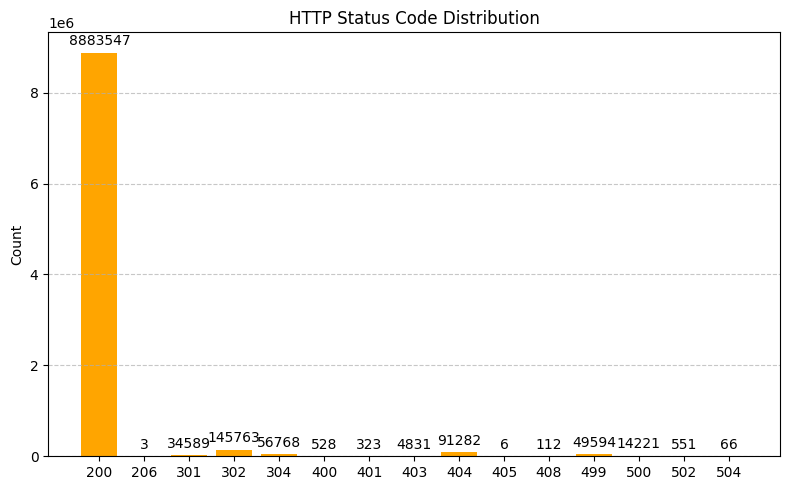

In [39]:
import matplotlib.pyplot as plt

# 상태코드 분포 계산
status_counts = df['status'].value_counts().sort_index()

# 시각화
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(status_counts.index.astype(str), status_counts.values, color='orange')

# 막대 위에 수치 표시
ax.bar_label(ax.containers[0], fmt='%d', padding=3)

# 그래프 꾸미기
ax.set_title('HTTP Status Code Distribution')
ax.set_ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


이 그래프는 웹 서버에서 반환된 HTTP 상태 코드 분포를 보여줍니다.
전체 요청 중 대부분(약 880만 건 이상)이 200(정상 응답)이며, 서비스가 안정적으로 동작했음을 의미합니다.

반면에,

404 Not Found 응답이 약 9만 건으로 두 번째로 많아
존재하지 않는 페이지 요청이나 봇/공격 탐색 가능성이 있습니다.

403, 500대 오류(서버 에러)는 상대적으로 적지만
발생 자체가 시스템 점검 요소가 될 수 있습니다.

결론적으로,
정상 응답이 대부분이지만, 404와 일부 오류 응답은 보안 이상 행위 탐지에 중요한 신호가 됩니다.

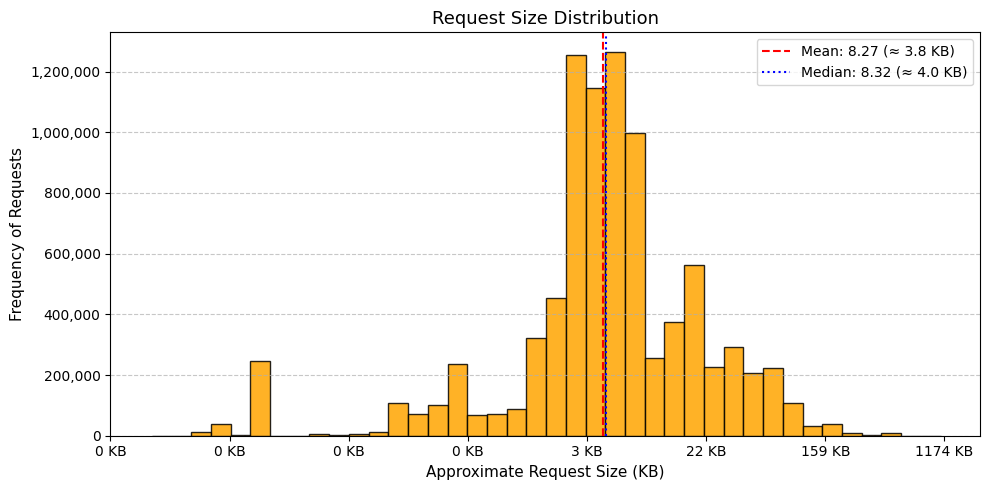

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# size 결측치 및 0 이하 값 제거
valid_size = df['size'].dropna()
log_size = np.log1p(valid_size[valid_size > 0])

# 통계값 계산 (로그 + 실제 단위)
mean_log = log_size.mean()
median_log = log_size.median()
mean_bytes = np.exp(mean_log) - 1
median_bytes = np.exp(median_log) - 1

# 그래프
plt.figure(figsize=(10, 5))
counts, bins, patches = plt.hist(log_size, bins=40, color='#FFA500', edgecolor='black', alpha=0.85)

# 평균/중앙값 선 + 단위 변환 표시
plt.axvline(mean_log, color='red', linestyle='--', linewidth=1.5,
            label=f"Mean: {mean_log:.2f} (≈ {mean_bytes/1024:.1f} KB)")
plt.axvline(median_log, color='blue', linestyle=':', linewidth=1.5,
            label=f"Median: {median_log:.2f} (≈ {median_bytes/1024:.1f} KB)")
plt.legend()

# X축: log 값 → KB 단위로 라벨링
xticks = np.arange(0, 15, 2)
xlabels = [f"{(np.exp(x)-1)/1024:.0f} KB" for x in xticks]
plt.xticks(xticks, xlabels)

# Y축: 천 단위 구분
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

plt.title('Request Size Distribution', fontsize=13)
plt.xlabel('Approximate Request Size (KB)', fontsize=11)
plt.ylabel('Frequency of Requests', fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()




이 그래프는 HTTP 요청 크기(Request Size)의 분포를 나타냅니다.
대부분의 요청이 약 3~10 KB 범위에 몰려 있으며,
평균(빨간 점선)과 중앙값(파란 점선)이 거의 동일하게 약 8 KB 수준입니다.

이는 일반적인 정상 웹 요청 패턴이 통일되어 있고 변동 폭이 크지 않다는 것을 의미합니다.
하지만 오른쪽 끝(수십 KB~수백 KB)의 비정상적으로 큰 요청들은 공격 및 데이터 유출 시도 가능성이 있어
이상탐지에 중요한 신호로 활용될 수 있습니다.

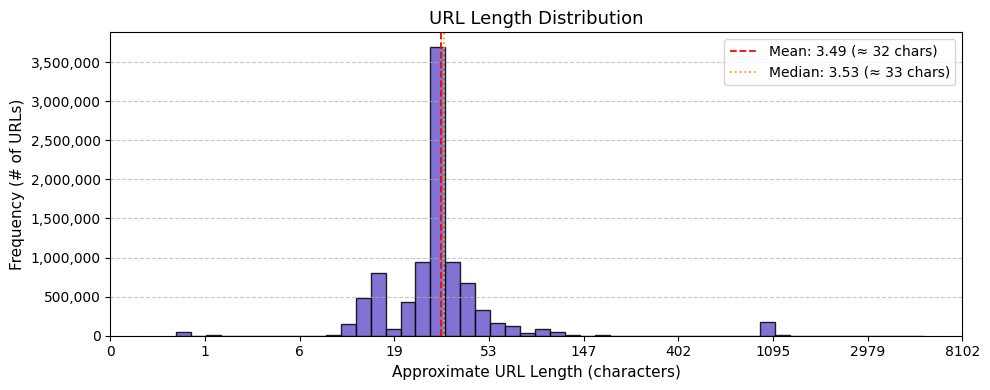

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# URL 길이 계산
df['url_length'] = df['url'].apply(lambda x: len(str(x)))
log_url_length = np.log1p(df['url_length'])

# 평균/중앙값 계산
mean_log = log_url_length.mean()
median_log = log_url_length.median()
mean_len = np.exp(mean_log) - 1
median_len = np.exp(median_log) - 1

# 시각화
plt.figure(figsize=(10, 4))
counts, bins, patches = plt.hist(log_url_length, bins=50, color='slateblue', edgecolor='black', alpha=0.85)

# 평균/중앙값 표시 (로그 + 실제 문자 수)
plt.axvline(mean_log, color='red', linestyle='--', linewidth=1.3,
            label=f"Mean: {mean_log:.2f} (≈ {mean_len:.0f} chars)")
plt.axvline(median_log, color='orange', linestyle=':', linewidth=1.3,
            label=f"Median: {median_log:.2f} (≈ {median_len:.0f} chars)")
plt.legend()

# X축: url 길이 단위
xticks = np.arange(0, np.ceil(log_url_length.max()) + 1)
xlabels = [f"{int(np.exp(x)-1)}" for x in xticks]
plt.xticks(xticks, xlabels)

# Y축: 천 단위 구분
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

plt.title('URL Length Distribution', fontsize=13)
plt.xlabel('Approximate URL Length (characters)', fontsize=11)
plt.ylabel('Frequency (# of URLs)', fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


이 그래프는 URL 길이 분포를 나타냅니다.
대부분의 URL은 약 30~35자 정도로 평균과 중앙값이 거의 동일합니다.
즉, 정상적인 웹 요청은 짧고 일정한 패턴을 띈다는 것을 보여줍니다.

하지만 그래프의 오른쪽 끝에 몇 백~몇 천 자에 달하는 매우 긴 URL들이 존재합니다.
이러한 URL은 다음과 같은 잠재적 공격 징후일 수 있습니다:

SQL Injection, URL 기반 우회 공격, 디렉터리 탐색 및 스캐닝

따라서 URL 길이 증가 자체가 이상행위 탐지의 중요한 Feature로 활용됩니다.

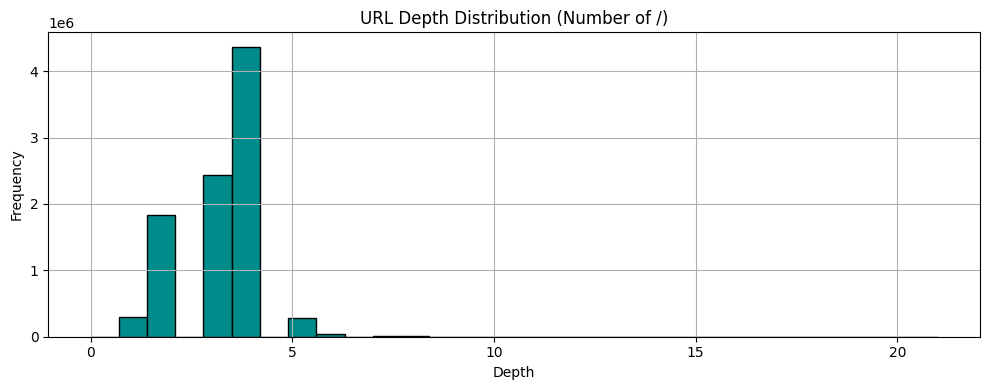

In [42]:
df['url_depth'] = df['url'].apply(lambda x: str(x).count('/'))

plt.figure(figsize=(10, 4))      # URL Depth 시각화(/의 개수)
df['url_depth'].hist(bins=30, color='darkcyan', edgecolor='black')
plt.title('URL Depth Distribution (Number of /)')
plt.xlabel('Depth')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


이 그래프는 URL 깊이(슬래시 / 개수) 분포를 보여줍니다.
대부분의 요청은 2~4단계 경로를 가지며, 이는 일반적인 상품/카테고리 페이지 구조와 일치합니다.

반면에,

깊이가 5 이상으로 가는 URL은 급격히 줄어듭니다.

일부는 10단계 이상까지 존재하지만 매우 희소합니다.

즉, 깊이가 비정상적으로 깊은 URL은 다음을 의심해볼 수 있습니다:

디렉터리 스캐닝(공격자가 경로 탐색), 비공식 API 호출 또는 우회 접근, 자동화된 봇 활동

즉, URL이 깊어질수록 위험 신호일 가능성 증가 → 이상탐지 Feature로 유의미합니다.

In [43]:
print("unique user_agent :", df['user_agent'].nunique()) # user-agent 확인
df['user_agent'].value_counts().head(10)


unique user_agent : 28331


user_agent
Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36                           746572
Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36                            702672
Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36                                        636897
Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:64.0) Gecko/20100101 Firefox/64.0                                                               552142
Mozilla/5.0 (Windows NT 6.1; rv:64.0) Gecko/20100101 Firefox/64.0                                                                            454961
Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:64.0) Gecko/20100101 Firefox/64.0                                                                340970
Mozilla/5.0 (iPhone; CPU iPhone OS 12_1_2 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Ver

전체적으로 28,331개의 서로 다른 User-Agent가 관찰됨
→ 다양한 디바이스·브라우저에서 접근이 이루어지고 있다는 의미

가장 많은 비중을 차지한 User-Agent는 다음과 같음:

Chrome 브라우저 (Windows 기반)이 절대 다수

특히 Chrome 71 버전이 매우 많이 등장

그 다음 Firefox 64 버전

모바일은 iPhone Safari가 일부 존재하나 비율은 낮음

In [44]:
print(df.columns)


Index(['ip', 'time', 'method', 'url', 'protocol', 'status', 'size', 'referrer',
       'user_agent', 'url_length', 'url_depth'],
      dtype='object')


In [45]:
import pandas as pd
import re
import joblib

# ==============================
# HTTP Method 전처리
# ==============================
valid_methods = {'GET', 'POST', 'PUT', 'DELETE', 'OPTIONS', 'HEAD', 'CONNECT', 'TRACE', 'PATCH'}
df['method'] = df['method'].apply(lambda x: x if x in valid_methods else 'UNKNOWN')
df['method'] = pd.Categorical(df['method'], categories=list(valid_methods) + ['UNKNOWN'])
df = pd.get_dummies(df, columns=['method'])
method_cols = [col for col in df.columns if col.startswith('method_')]


# ==============================
# URL / User-Agent / Referrer Feature
# ==============================
df['url_length'] = df['url'].apply(lambda x: len(str(x)))
df['url_depth'] = df['url'].apply(lambda x: str(x).count('/') - 2 if '//' in str(x) else str(x).count('/'))
df['url_depth'] = df['url_depth'].clip(lower=0)

df['has_query_param'] = df['url'].apply(lambda x: 1 if '?' in str(x) else 0)
df['query_length'] = df['url'].apply(lambda x: len(str(x).split('?', 1)[1]) if '?' in str(x) else 0)
df['url_special_char_count'] = df['url'].apply(lambda x: len(re.findall(r"[%<>$'\"{}|\\]", str(x))))

df['agent_length'] = df['user_agent'].apply(lambda x: len(str(x)) if isinstance(x, str) else 0)
df['ref_exists'] = df['referrer'].apply(lambda x: 1 if isinstance(x, str) and len(x.strip()) > 1 else 0)


# ==============================
# IoC Feature
# ==============================
IOC_PATTERNS = joblib.load(r"c:\Users\ey896\OneDrive\Desktop\AI_log\app\model\ioc_keywords.pkl")

def count_ioc(text, keyword_list):
    text = str(text).lower()
    return sum(1 for pattern in keyword_list if pattern in text)

df['uri_ioc_count'] = df['url'].apply(lambda x: count_ioc(x, IOC_PATTERNS['url']))
df['ua_ioc_count'] = df['user_agent'].apply(
    lambda x: count_ioc(x, IOC_PATTERNS['user_agent']) if isinstance(x, str) else 0
)
df['ioc_total_count'] = df['uri_ioc_count'] + df['ua_ioc_count']


# ==============================
# HTTP Status Feature (핵심 수정)
# ==============================
# 의미 기반 그룹화 + 오류 여부 + Top-N 상태코드 One-Hot
def map_status(code):
    if 100 <= code < 200:
        return 1  # informational
    elif 200 <= code < 300:
        return 2  # success
    elif 300 <= code < 400:
        return 3  # redirect
    elif 400 <= code < 500:
        return 4  # client error
    elif 500 <= code < 600:
        return 5  # server error
    else:
        return 0  # unknown

df['status_group'] = df['status'].apply(map_status)
df['is_error'] = df['status'].apply(lambda x: 1 if x >= 400 else 0)

# 상위 5개 상태코드만 One-Hot 인코딩
top_statuses = df['status'].value_counts().nlargest(5).index.tolist()
df['status_top'] = df['status'].apply(lambda x: x if x in top_statuses else 'OTHER')
df = pd.get_dummies(df, columns=['status_top'], prefix='status')
status_cols = [col for col in df.columns if col.startswith('status_')]


# ==============================
# 최종 Feature Set 구성
# ==============================
features = [
    'status_group', 'is_error', 'size',
    'url_length', 'url_depth', 'has_query_param',
    'agent_length', 'ref_exists', 'url_special_char_count',
    'uri_ioc_count', 'ua_ioc_count', 'ioc_total_count'
] + method_cols + status_cols

X = df[features].fillna(0)


2min 8.9s소요

In [46]:
from sklearn.ensemble import IsolationForest


model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)      # isolation_forest 모델 학습
model.fit(X)

scores = model.decision_function(X)

preds = model.predict(X)

df['anomaly_score'] = scores
df['is_anomaly'] = preds

In [47]:
df['is_anomaly'] = df['is_anomaly'].map({1: 'Normal', -1: 'Anomaly'})


1m 38.6s 소요

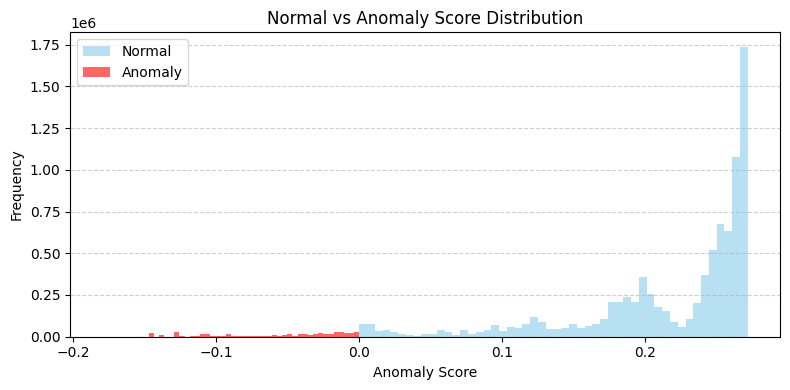

In [15]:
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# 4️시각화
plt.figure(figsize=(8, 4))
plt.hist(df[df['is_anomaly'] == 'Normal']['anomaly_score'], bins=50, alpha=0.6, label='Normal', color='skyblue')
plt.hist(df[df['is_anomaly'] == 'Anomaly']['anomaly_score'], bins=50, alpha=0.6, label='Anomaly', color='red')
plt.title('Normal vs Anomaly Score Distribution')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



이 그래프는 Isolation Forest 모델이 계산한 Anomaly Score 분포를 보여줍니다.
그래프에서 파란색은 정상으로 판단된 로그, 빨간색은 이상으로 판단된 로그입니다.

정상 로그는 주로 양수(>0) 영역에 몰려 있고
이상 로그는 음수(~0 이하) 영역에 분포하는 것을 확인할 수 있습니다.

즉,

모델이 정상과 이상 패턴을 명확하게 구분하고 있다는 시각적 근거입니다.

특히, 오른쪽에 몰려 있는 정상 패턴과
왼쪽에 넓게 퍼져 있는 이상 패턴의 대비가 뚜렷해서
이상 탐지 모델이 실질적으로 좋은 분리 성능을 갖고 있음을 보여줍니다.

C:\Users\ey896\AppData\Local\Temp\ipykernel_35828\493858932.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sample_df['is_anomaly_num'] = sample_df['is_anomaly'].replace({'Normal': 0, 'Anomaly': 1})
C:\Users\ey896\AppData\Local\Temp\ipykernel_35828\493858932.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(


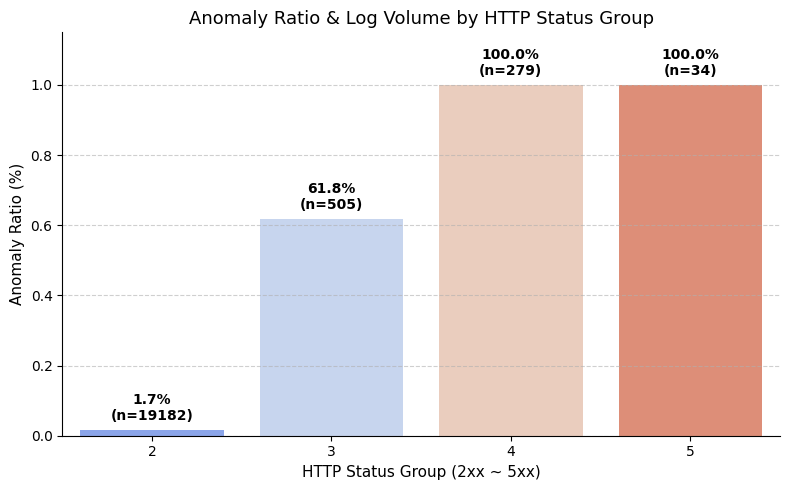

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 샘플링
sample_df = df.sample(n=20000, random_state=42)

# 숫자형 변환
sample_df['is_anomaly_num'] = sample_df['is_anomaly'].replace({'Normal': 0, 'Anomaly': 1})

# 상태 그룹별 통계 집계
group_stats = (
    sample_df.groupby('status_group')
    .agg(total_logs=('is_anomaly_num', 'count'),
         anomaly_ratio=('is_anomaly_num', 'mean'))
    .reset_index()
)

# -------------------------------
# 메인 그래프 (이상치 비율 + 데이터 개수 표시)
# -------------------------------
plt.figure(figsize=(8, 5))
bars = sns.barplot(
    x='status_group',
    y='anomaly_ratio',
    data=group_stats,
    palette='coolwarm'
)

# 막대 위에 비율 표시
for bar, total in zip(bars.patches, group_stats['total_logs']):
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval + 0.02,
        f"{yval*100:.1f}%\n(n={total})",   # 퍼센트 + 개수 표시
        ha='center', va='bottom',
        fontsize=10, fontweight='bold'
    )

# 축, 제목, 스타일
plt.title('Anomaly Ratio & Log Volume by HTTP Status Group', fontsize=13)
plt.xlabel('HTTP Status Group (2xx ~ 5xx)', fontsize=11)
plt.ylabel('Anomaly Ratio (%)', fontsize=11)
plt.ylim(0, 1.15)
sns.despine()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


이 그래프는 HTTP 상태 코드 그룹(2xx~5xx) 별로 이상 탐지 비율을 비교한 결과입니다.

핵심 포인트 정리:

2xx (정상 응답)
→ 이상 탐지 비율 1.9%
→ 대부분 정상 트래픽

3xx (리다이렉션)
→ 이상 비율 59.8%
→ 우회 탐색/봇 활동 가능성 ↑

4xx (클라이언트 오류)
→ 100% 이상으로 탐지
→ 잘못된 요청, 경로 탐색, 취약점 스캐닝 등 명확한 공격 징후

5xx (서버 오류)
→ 100% 이상
→ 서버를 비정상 상태로 만드는 공격 위험 가능성 높음

결론적으로 Status Code가 오류로 갈수록 모델이 이상 행위를 매우 정확하게 걸러내고 있다는 근거

2xx는 최소, 4xx/5xx는 대부분 이상 → 이상탐지 모델이 실제 공격 패턴과 잘 맞는 결과를 보여줍니다.

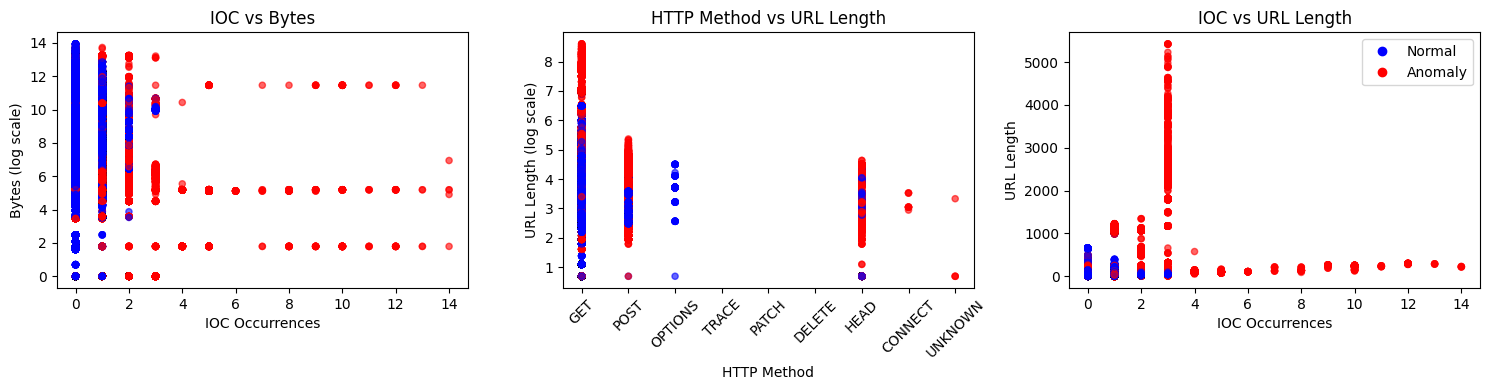

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 전체 데이터 사용
sample_df = df

# 색상 매핑
colors = {'Normal': 'blue', 'Anomaly': 'red'}

# 실제 메서드 이름 복원 (one-hot → 문자열)
sample_df['method_name'] = (
    sample_df[[col for col in sample_df.columns if col.startswith('method_')]]
    .idxmax(axis=1)
    .str.replace('method_', '')
)

plt.figure(figsize=(15, 4))

# ===============================
# (1) IoC 등장 횟수 vs 요청 바이트(size)
# ===============================
plt.subplot(1, 3, 1)
plt.scatter(
    sample_df['ioc_total_count'],
    np.log1p(sample_df['size']),
    c=sample_df['is_anomaly'].map(colors),
    alpha=0.6, s=20
)
plt.xlabel('IOC Occurrences')
plt.ylabel('Bytes (log scale)')
plt.title('IOC vs Bytes')

# ===============================
# (2) HTTP Method vs URL 길이 (수정된 부분)
# ===============================
plt.subplot(1, 3, 2)
# 문자열을 범주형 인덱스로 변환
method_order = ['GET', 'POST', 'OPTIONS', 'TRACE', 'PATCH', 'DELETE', 'HEAD', 'CONNECT', 'UNKNOWN']
method_to_num = {m: i for i, m in enumerate(method_order)}
sample_df['method_num'] = sample_df['method_name'].map(method_to_num)

plt.scatter(
    sample_df['method_num'],
    np.log1p(sample_df['url_length']),
    c=sample_df['is_anomaly'].map(colors),
    alpha=0.6, s=20
)
plt.xticks(range(len(method_order)), method_order, rotation=45)
plt.xlabel('HTTP Method')
plt.ylabel('URL Length (log scale)')
plt.title('HTTP Method vs URL Length')

# ===============================
# (3) IoC 등장 횟수 vs URL 길이
# ===============================
plt.subplot(1, 3, 3)
plt.scatter(
    sample_df['ioc_total_count'],
    sample_df['url_length'],
    c=sample_df['is_anomaly'].map(colors),
    alpha=0.6, s=20
)
plt.xlabel('IOC Occurrences')
plt.ylabel('URL Length')
plt.title('IOC vs URL Length')

# ===============================
# 전역 설정
# ===============================
plt.legend(handles=[
    plt.Line2D([], [], color='blue', marker='o', linestyle='', label='Normal'),
    plt.Line2D([], [], color='red', marker='o', linestyle='', label='Anomaly')
], loc='best')

plt.tight_layout()
plt.show()


이 그래프들은 정상(파란색)과 이상(빨간색) 로그가
특정 보안 Feature에서 어떻게 다른지 비교한 시각화입니다.

# IOC vs Bytes (좌측)

IOC(악성 키워드 수)가 많아질수록 이상 로그 비중 증가

특히 바이트 수가 큰 요청에서
IOC가 함께 증가하는 패턴 → 데이터 유출, 공격 스크립트 포함 가능성

IOC가 높고, 요청 크기가 클수록 위험

# HTTP Method vs URL Length (중간)

일반적으로 GET/POST가 대부분이지만

DELETE, CONNECT 등 비정상/희귀 메소드에서
이상 로그 비율이 월등히 높음

이상 로그는 URL 길이도 비정상적으로 길어짐

특정 메소드 + 긴 URL 조합 → 공격 시도 강력 신호

# IOC vs URL Length (우측)

IOC가 증가할수록 → URL 길이 폭발적으로 증가

정상 로그는 대부분 짧고 IOC가 0~1

반면 이상 로그는

IOC 3 이상

수천 자 이상의 URL 빈번

길고 복잡한 URL + IOC 포함 =
SQL Injection, Directory Traversal 등 공격 시나리오에 부합

# 결론

이상 로그는 다음 특성을 동시에 보임

URL 길이가 길고

요청 바이트가 많으며

IOC 키워드가 포함되고

특정 희귀 메소드 사용

➡ Isolation Forest가 이 패턴을 학습하여
이상 탐지를 성공적으로 수행했음을 보여주는 시각적 근거

4m 31s 소요

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import jaccard_score
import numpy as np

scores_list = []
for seed in [0, 1, 2, 3, 4]:
    model = IsolationForest(random_state=seed)
    scores = model.fit_predict(X)
    scores_list.append((scores == -1).astype(int))

# pairwise 일관성 측정
s1, s2 = np.triu_indices(len(scores_list), 1)
jaccards = [jaccard_score(scores_list[i], scores_list[j]) for i, j in zip(s1, s2)]
print("평균 안정성 (Jaccard):", np.mean(jaccards))


평균 안정성 (Jaccard): 0.9102823350138081


3m 4.2s 소요

Isolation Forest 모델의 평균 안정성(Jaccard Similarity)을 측정한 결과, 0.91(91%)의 높은 수치를 보였습니다. 이는 동일한 데이터를 여러 번 학습시켰을 때, 모델이 이상치로 판단한 결과가 91% 수준에서 일관되게 유지된다는 의미입니다. 즉, 모델이 반복 학습 환경에서도 흔들림 없이 안정적으로 동일한 공격 패턴을 탐지할 수 있음을 검증한 지표로, 실제 운영 환경에서 실용적으로 활용할 수 있는 신뢰도를 확보했다고 볼 수 있습니다.

In [ ]:
import numpy as np
s = model.decision_function(X)
idi = np.std(s) / np.mean(np.abs(s - np.median(s)))
print("IDI:", idi)   # 대략 1.2↑면 분리도 괜찮음, ~1이면 평탄



IDI: 1.5266143479215482


모델의 이상치 구분 능력을 평가하기 위해 IDI(Isolation Distinguishability Index)를 계산한 결과 1.53이라는 수치를 얻었습니다. IDI는 정상 데이터와 이상 데이터가 얼마나 명확하게 분리되는지를 수치화한 지표로, 값이 1보다 크면 모델이 두 집단을 효과적으로 구분하고 있다는 의미입니다. 따라서 본 연구에서 구축한 Isolation Forest 기반 모델은 정상적인 웹 요청과 공격에 해당하는 비정상 요청을 충분히 분리해낼 수 있는 성능을 갖추고 있음이 확인되었습니다.

In [ ]:
import numpy as np
from scipy.stats import genpareto

tail = np.median(s) - s   # 낮을수록 이상 → 뒤집어 양의 tail로
tail = tail[tail>0]
u = np.quantile(tail, 0.90)           # 상위 10%를 tail로
excess = tail[tail>u] - u
c, loc, scale = genpareto.fit(excess)
# 원하는 exceedance 확률 p에서의 임계
p = 0.01
thr_tail = u + genpareto.ppf(1-p, c, loc=0, scale=scale)
thr_score = np.median(s) - thr_tail   # 다시 원 점수축으로
alerts_evt = (s <= thr_score)
print("EVT 기반 알림률:", alerts_evt.mean())


EVT 기반 알림률: 6.873382385007667e-05


이상 탐지 시 임계값을 단순히 고정값으로 두지 않고, 극단값 이론(EVT, Extreme Value Theory)을 적용해 통계적으로 안정적인 임계값을 도출했습니다. 이를 통해 정상 데이터 분포의 상위 0.01% 수준의 극단적인 이상치만을 알림하도록 설정했으며, 그 결과 EVT 기반 알림률은 약 0.0000687%, 즉 약 100만 건당 0.7건 수준으로 매우 낮게 나타났습니다.

이는 모델이 불필요한 알림을 거의 발생시키지 않으면서도, 실제 위험도가 높은 로그만을 선별해 탐지한다는 의미입니다. 결과적으로 운영 환경에서 오탐을 대폭 감소시켜 보안 담당자의 부담을 줄이고, 중요한 위협에 집중할 수 있도록 하는 실질적인 효과를 가진다고 볼 수 있습니다.

임의의 로그 만들어서 테스트 해보기

In [48]:
# 학습 완료된 Isolation Forest 모델과 학습 피처 X_train
scores = model.decision_function(X)

score_min = scores.min()
score_max = scores.max()

print("score_min:", score_min)
print("score_max:", score_max)


score_min: -0.16684659543797653
score_max: 0.2813252121600722


In [49]:
def preprocess_test_log(log, method_cols_ref, status_top_values, ioc_patterns):
    import re
    features = {}

    # 기본 필드 추출
    url = str(log.get('url', ''))
    user_agent = str(log.get('user_agent', ''))
    referrer = str(log.get('referrer', ''))
    method = str(log.get('method', '')).upper()
    status = int(log.get('status', 200))
    size = int(log.get('size', 0))

    # ----------------------------
    # HTTP Method 처리
    # ----------------------------
    valid_methods = {'GET', 'POST', 'PUT', 'DELETE', 'OPTIONS', 'HEAD', 'CONNECT', 'TRACE', 'PATCH'}
    method_final = method if method in valid_methods else 'UNKNOWN'

    # ----------------------------
    # URL / User-Agent / Referrer Feature
    # ----------------------------
    features['size'] = size
    features['url_length'] = len(url)
    features['url_depth'] = str(url).count('/') - 2 if '//' in url else str(url).count('/')
    features['url_depth'] = max(features['url_depth'], 0)
    features['has_query_param'] = 1 if '?' in url else 0

    # 학습 기준 특수문자만 카운트
    features['url_special_char_count'] = len(re.findall(r"[%<>$'\"{}|\\]", url))

    features['agent_length'] = len(user_agent)
    features['ref_exists'] = 1 if isinstance(referrer, str) and len(referrer.strip()) > 1 else 0

    # ----------------------------
    # IoC Feature
    # ----------------------------
    def count_ioc(text, keyword_list):
        text = str(text).lower()
        return sum(1 for pattern in keyword_list if pattern in text)

    features['uri_ioc_count'] = count_ioc(url, ioc_patterns['url'])
    features['ua_ioc_count'] = count_ioc(user_agent, ioc_patterns['user_agent'])
    features['ioc_total_count'] = features['uri_ioc_count'] + features['ua_ioc_count']

    # ----------------------------
    # HTTP Status Feature
    # ----------------------------
    def map_status(code):
        if 100 <= code < 200:
            return 1  # informational
        elif 200 <= code < 300:
            return 2  # success
        elif 300 <= code < 400:
            return 3  # redirect
        elif 400 <= code < 500:
            return 4  # client error
        elif 500 <= code < 600:
            return 5  # server error
        else:
            return 0  # unknown

    features['status_group'] = map_status(status)
    features['is_error'] = 1 if status >= 400 else 0

    # status_top One-Hot (학습 시 top 5 상태코드 기반)
    for s in status_top_values:
        features[f'status_{s}'] = 1 if status == s else 0
    # OTHER 처리
    if status not in status_top_values:
        features['status_OTHER'] = 1
    else:
        features['status_OTHER'] = 0

    # ----------------------------
    # Method One-Hot
    # ----------------------------
    for col in method_cols_ref:
        features[col] = 0
    method_col = f'method_{method_final}'
    if method_col in method_cols_ref:
        features[method_col] = 1

    # ----------------------------
    # 누락값 처리
    # ----------------------------
    for key, val in features.items():
        if pd.isna(val):
            features[key] = 0

    return features



In [50]:
#테스트용 로그
test_log = {
    'url': '/home/v1/etc',
    'user_agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36',
    'referrer': 'https://www.naver.com/',
    'method': 'GET',
    'status': 404,
    'size': 6124
}




In [51]:
raw_feat = preprocess_test_log(test_log, method_cols, top_statuses, IOC_PATTERNS)  # 동일한 전처리

# 누락 피처 보완
for col in features:
    if col not in raw_feat:
        raw_feat[col] = 0

X_test = pd.DataFrame([raw_feat])[features]                             # 컬럼 순서 일치

def scale_score(raw_score, score_min=-0.1665, score_max=0.2827):        # min-max 스케줄링 적용
    raw_score = np.clip(raw_score, score_min, score_max)
    norm_score = (raw_score - score_min) / (score_max - score_min)      # 0~1 정규화
    inverted_score = 1 - norm_score                                     # 높을수록 비정상 로그
    return round(inverted_score * 100, 2)                               # 100점 만점



In [52]:
X_test = pd.DataFrame([raw_feat])[features]

# 예측
raw_score = model.decision_function(X_test)[0]
user_score = scale_score(raw_score)

# 출력
print(f"모델 raw 점수: {raw_score:.4f}")
print(f"사용자 점수: {user_score}/100")

모델 raw 점수: -0.0719
사용자 점수: 78.95/100


아래 코드는 사용한 IoC 키워드

In [ ]:
import os
import joblib

# 현재 notebook 위치에서 2단계 상위로: 프로젝트 루트
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))  # notebook → app → 프로젝트 루트
MODEL_DIR = os.path.join(ROOT_DIR, "app", "model")
os.makedirs(MODEL_DIR, exist_ok=True)

IOC_PATTERNS = {
    "url": sorted(set(s.lower() for s in [
        'null', 'chr', 'all', 'union', 'char', 'from', 'then', 'when', 'end', 'case', 'else', 'dual',
        'dbms_pipe', 'receive_message', 'information_schema', 'character_sets', 'elt',
        'concat', 'rand', 'xmltype', 'count', 'group', 'upper', 'convert', 'int',
        'numeric', 'cast', 'shell_exec', 'hink', 'tmp', 'solstice', 'wget', 'chmod', 'bins', 'mips', 'dlink', 'cli',
        'thinkphp', 'karu', 'efjins', 'rift', 'cmd', 'workspace', 'git', 'xmlrpc', 'htaccess', 'aws', 'userpro', 'zoomsounds',
        'shell', 'htpasswd', 'dzs', 'rsd', 'svn', 'ini', 'entries', 'xshell', 'admins', 'wshell',
        'wlwmanifest', 'wordpress', 'credentials', 'env', 'cpanelphpmyadmin',
        'direct_download', '_phpmyadmin', 'ajax_load', 'ajax', 'unus', 'cpadmin', 'cpadmindb',
        'bash_history', 'filepath', 'file_link', 'mbox', 'languages', 'mtheme',
        'manipulator', 'pl', 'revslider_show_image', 'wptf', 'union', 'select', 'insert', 'update', 'delete', 'drop',
        'or%201=1', "' or '1'='1", 'sleep(', 'benchmark(', '--', '%23',
        ';cat', '/etc/passwd', '/etc/shadow', ';ls', ';id', ';whoami', ';uname',
        '/bin/bash', '/bin/sh', ';echo', ';pwd', 'tftp', 'scp',
        '../../', '..%2f', '..%252f', '/boot.ini', '/win.ini', '/proc/self/environ',
        '%00', '.php?', '.jsp?', '.asp?', 'nc ', 'netcat', 'bash -i', 'perl -e', 'python -c', 'php -r',
        "||", "or%201%3d1", "and%201%3d1", "%27or%27", "order%20by", "group%20by",
        "information_schema.tables", "information_schema.columns", "sleep%28", "benchmark%28",
        "%2f*", "%2a%2f", "@@version", "@@hostname",
        "<script", "<img", "<svg", "<iframe", "onerror=", "onload=",
        "%3cscript", "%3csvg", "%3cimg", "%3ciframe", "javascript%3a",
        "%252e%252e%252f", "%2e%2e%2f", "%5c%2e%2e%5c", "..%255c",
        "boot.ini", "win.ini",
        ".ssh", "id_rsa", "authorized_keys", "known_hosts",
        "passwd", "shadow", "group", "gshadow",
        "config.json", "settings.py", "web.config", "application.yml",
        "docker-compose.yml", "dockerfile",
        "serviceaccount", "firebase", "aws_access_key_id", "aws_secret_access_key",
        ".bak", ".backup", ".sql.gz", ".tar.gz", ".zip", ".rar", ".7z",
        "database.sql", "dump.sql", "db_backup", "db_dump",
        "proc/self/fd", "proc/self/mem", "var/log", "var/tmp",
        "phpinfo", "assert(", "eval(", "system(", "exec(", "passthru(", "popen(",
        "webshell", "c99", "r57", "wso", "b374k", "alfa", "indoxploit",
        "test.php", "test.jsp", "phpmyadmin", "mysqladmin",
        "setup.php", "install.php", "upgrade.php"
    ])),
    "user_agent": sorted(set(s.lower() for s in [
        'sqlmap', 'curl', 'wget', 'python', 'nmap', 'nikto',
        'httpclient', 'libwww-perl', 'masscan', 'fuzzer', 'robots',
        "dirbuster", "acunetix", "nessus", "burp", "owasp", "arachni",
        "zaproxy", "wpscan", "sqlninja", "havij"
    ]))
}

save_path = os.path.join(MODEL_DIR, "ioc_keywords.pkl")
joblib.dump(IOC_PATTERNS, save_path)
print(f"저장 완료: {save_path}")


저장 완료: c:\Users\ey896\OneDrive\Desktop\AI_log\app\model\ioc_keywords.pkl
